# Importation des paquets

In [1]:
import pandas as pd
import random
import numpy as np
import datetime
import matplotlib.pyplot as plt
from Levenshtein import distance as levenshtein_distance # Installer avec pip ou conda install levenshtein
from datetime import datetime
from itertools import groupby  # Installer avec pip ou conda
import networkx as nx  # Installer avec pip ou conda
import geopandas  # Installer avec pip ou conda

# Chargement du dataset

In [2]:
filename = 'thegurus-opendata-renfe-trips.csv'

# Echantillonage aléatoire systématique :

# On détermine l’intervalle d’échantillonnage (K), puis on sélectionne au hasard un nombre entre 1 et K.
# Ce nombre s’appelle l’origine choisie au hasard et ce sera le premier nombre inclus dans notre échantillon.
# On sélectionne chaque Kème unité après ce premier nombre.

def systematic_sampling(filename, K):
    origine = random.randint(1, K)
    df = pd.read_csv(filename, header=0, skiprows=lambda i: i>0 and (i%K != origine))
    return df

df = systematic_sampling(filename, 20)

df

,id,company,origin,destination,departure,arrival,duration,vehicle_type,vehicle_class,price,fare,seats,meta,insert_date
0,1,renfe,MADRID,BARCELONA,2019-04-18 05:50:00,2019-04-18 08:55:00,3.08,AVE,Preferente,68.95,Promo,NaN,{},2019-04-11 21:49:46
1,21,renfe,MADRID,BARCELONA,2019-04-18 13:25:00,2019-04-18 16:24:00,2.98,AVE-TGV,Turista,107.70,Flexible,NaN,{},2019-04-11 21:49:46
2,41,renfe,MADRID,BARCELONA,2019-04-18 07:00:00,2019-04-18 09:30:00,2.50,AVE,Turista Plus,106.75,Promo,NaN,{},2019-04-11 21:49:46
3,61,renfe,MADRID,BARCELONA,2019-05-18 17:30:00,2019-05-18 20:40:00,3.17,AVE,Turista,75.40,Promo,NaN,{},2019-04-11 21:49:48
4,81,renfe,MADRID,BARCELONA,2019-05-22 08:00:00,2019-05-22 10:30:00,2.50,AVE,Turista,100.40,Promo,NaN,{},2019-04-11 21:50:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1937648,38752961,renfe,BARCELONA,ZARAGOZA,2020-11-25 15:50:00,2020-11-25 17:30:12,1.67,AVE,Turista,27.40,Promo +,291.0,"{""Turista"": {""Promo +"": {""price"": 27.4, ""seats...",2020-10-07 12:00:00
1937649,38752981,renfe,BARCELONA,ZARAGOZA,2020-10-21 06:05:00,2020-10-21 07:45:48,1.68,AVE,Turista,35.95,Promo +,259.0,"{""Turista"": {""Promo +"": {""price"": 35.95, ""seat...",2020-10-07 12:00:00
1937650,38753001,renfe,ZARAGOZA,BARCELONA,2020-10-24 11:27:00,2020-10-24 16:37:12,5.17,REG.EXP.,NaN,NaN,NaN,NaN,{},2020-10-07 12:00:00
1937651,38753021,renfe,ZARAGOZA,BARCELONA,2020-10-23 16:39:00,2020-10-23 21:37:12,4.97,REG.EXP.,NaN,NaN,NaN,NaN,{},2020-10-07 12:00:00


# Description générale du dataset :

#### 1- Types de données :

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937653 entries, 0 to 1937652
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   id             int64  
 1   company        object 
 2   origin         object 
 3   destination    object 
 4   departure      object 
 5   arrival        object 
 6   duration       float64
 7   vehicle_type   object 
 8   vehicle_class  object 
 9   price          float64
 10  fare           object 
 11  seats          float64
 12  meta           object 
 13  insert_date    object 
dtypes: float64(3), int64(1), object(10)
memory usage: 207.0+ MB


#### 2- Nombre de valeurs manquantes par colonne :

In [4]:
cols = df.columns.tolist()

pd.DataFrame({
              'Colonne': 
              cols,
              
              'Nombre de valeurs manquantes': 
              [df[col].isnull().sum() for col in cols],
              
              'Pourcentage de valeurs manquantes': 
              [round(((df[col].isnull().sum())*100/(len(df.index))),2).astype(str)+' %' for col in cols],
              
              'Index des valeurs manquantes': 
              [list(df.loc[df[col].isnull()].index.values) for col in cols]
             })

,Colonne,Nombre de valeurs manquantes,Pourcentage de valeurs manquantes,Index des valeurs manquantes
0,id,0,0.0 %,[]
1,company,0,0.0 %,[]
2,origin,0,0.0 %,[]
3,destination,0,0.0 %,[]
4,departure,0,0.0 %,[]
5,arrival,0,0.0 %,[]
6,duration,0,0.0 %,[]
7,vehicle_type,0,0.0 %,[]
8,vehicle_class,401477,20.72 %,"[203, 226, 254, 477, 622, 997, 998, 1082, 1153..."
9,price,457079,23.59 %,"[30, 49, 50, 52, 63, 65, 115, 135, 138, 140, 1..."


#### 3- Nombre de valeurs uniques par colonne :

In [5]:
pd.DataFrame({
              'Colonne': 
              cols,
              
              'Nombre de valeurs uniques': 
              [df[col].nunique() for col in cols],
              
              'Pourcentage de valeurs uniques': 
              [str(round(((df[col].nunique())*100/(len(df.index))),5))+' %' for col in cols]
             })

,Colonne,Nombre de valeurs uniques,Pourcentage de valeurs uniques
0,id,1937653,100.0 %
1,company,1,5e-05 %
2,origin,30,0.00155 %
3,destination,30,0.00155 %
4,departure,82757,4.27099 %
5,arrival,99719,5.14638 %
6,duration,384,0.01982 %
7,vehicle_type,30,0.00155 %
8,vehicle_class,11,0.00057 %
9,price,1337,0.069 %


# Préparation des données :

#### 1- Suppression des colonnes 'seats', 'company', 'meta' et 'insert_date' :

la variable $\textit{'seats'}$ contient trop de valeurs manquantes (96.78 %). Le mieux serait d'éliminer cette variable.

In [6]:
df = df.drop('seats', axis=1)

La variable $\textit{'company'}$ admet une et une seule valeur, qui est $\textit{'renfe'}$. Ainsi, cette variable n'apportera aucune valeur ajoutée dans notre étude, et par conséquent sera éliminée à son tour.

In [7]:
df = df.drop('company', axis=1)

La variable $\textit{'meta'}$ ne contient aucune valeur manquante. Cependant, on voit que la valeur '{}' est présente dans 
environ 61% des lignes. Ainsi, cette variable ne nous sera pas utile dans notre étude, et sera supprimée aussi.

In [8]:
df['meta'].value_counts().head(3)

{}                                                             1187498
{"Turista": {"Adulto ida": {"price": 24.95, "seats": 257}}}       4457
{"Turista": {"Adulto ida": {"price": 28.35, "seats": 200}}}       4367
Name: meta, dtype: int64

In [9]:
print("Pourcentage de lignes ayant '{}' au niveau de la colonne 'meta' = "
      + round(((df['meta'].value_counts()[0])*100/(len(df.index))),2).astype(str)+' %')

Pourcentage de lignes ayant '{}' au niveau de la colonne 'meta' = 61.29 %


In [10]:
df = df.drop('meta', axis=1)

La variable $\textit{'insert_date'}$ correspond à la date d'insertion de l'enregistrement dans la base de données, et 
donc n'est pas utile dans notre cas. Par conséquent, on la supprime à son tour.

In [11]:
df = df.drop('insert_date', axis=1)

#### 2- Traitement des dates :

Les variables $\textit{'departure'}$, $\textit{'arrival'}$ et $\textit{'insert_date'}$ doivent être converties en datetime.

Donald >> On peut effacer directement 'insert data' et après avoir créé les nouvelles colones, suprimer departure et arrival

In [12]:
df['departure'] = pd.to_datetime(df['departure'], format='%Y-%m-%d %H:%M:%S')
df['arrival'] = pd.to_datetime(df['arrival'], format='%Y-%m-%d %H:%M:%S')

On voudrait ajouter 6 nouvelles colonnes :

In [13]:
df['departure_day'] = df['departure'].apply(lambda x: x.strftime("%A"))
df['departure_date'] = df['departure'].dt.date
df['departure_time'] = df['departure'].dt.time

df['arrival_day'] = df['arrival'].apply(lambda x: x.strftime("%A"))
df['arrival_date'] = df['arrival'].dt.date
df['arrival_time'] = df['arrival'].dt.time

cols = df.columns.tolist()
cols = cols[0:4] + cols[-6:-3] + [cols[4]] + cols[-3:] + cols[5:-6]

df = df[cols]

In [14]:
df.head()

,id,origin,destination,departure,departure_day,departure_date,departure_time,arrival,arrival_day,arrival_date,arrival_time,duration,vehicle_type,vehicle_class,price,fare
0,1,MADRID,BARCELONA,2019-04-18 05:50:00,Thursday,2019-04-18,05:50:00,2019-04-18 08:55:00,Thursday,2019-04-18,08:55:00,3.08,AVE,Preferente,68.95,Promo
1,21,MADRID,BARCELONA,2019-04-18 13:25:00,Thursday,2019-04-18,13:25:00,2019-04-18 16:24:00,Thursday,2019-04-18,16:24:00,2.98,AVE-TGV,Turista,107.70,Flexible
2,41,MADRID,BARCELONA,2019-04-18 07:00:00,Thursday,2019-04-18,07:00:00,2019-04-18 09:30:00,Thursday,2019-04-18,09:30:00,2.50,AVE,Turista Plus,106.75,Promo
3,61,MADRID,BARCELONA,2019-05-18 17:30:00,Saturday,2019-05-18,17:30:00,2019-05-18 20:40:00,Saturday,2019-05-18,20:40:00,3.17,AVE,Turista,75.40,Promo
4,81,MADRID,BARCELONA,2019-05-22 08:00:00,Wednesday,2019-05-22,08:00:00,2019-05-22 10:30:00,Wednesday,2019-05-22,10:30:00,2.50,AVE,Turista,100.40,Promo


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937653 entries, 0 to 1937652
Data columns (total 16 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              int64         
 1   origin          object        
 2   destination     object        
 3   departure       datetime64[ns]
 4   departure_day   object        
 5   departure_date  object        
 6   departure_time  object        
 7   arrival         datetime64[ns]
 8   arrival_day     object        
 9   arrival_date    object        
 10  arrival_time    object        
 11  duration        float64       
 12  vehicle_type    object        
 13  vehicle_class   object        
 14  price           float64       
 15  fare            object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(11)
memory usage: 236.5+ MB


On voudrait aussi ajouter une colonne $\textit{'duration (d,H,M,S)'}$ qui calcule la durée qui sépare le temps de départ et le
temps d'arrivée, et affiche le résultat sous la forme (days, hours, minutes, seconds) :

In [16]:
def duration(departure_time, arrival_time):
    
    duration = arrival_time - departure_time
    
    days = duration.days
    seconds = divmod(duration.seconds, 60)[1]
    minutes = divmod(divmod(duration.seconds, 60)[0], 60)[1]
    hours = divmod(divmod(duration.seconds, 60)[0], 60)[0]

    return days, hours, minutes, seconds

In [17]:
df['duration (d,H,M,S)'] = df.apply (lambda row: duration(row.departure, row.arrival), axis=1)

cols = df.columns.tolist()
cols = cols[0:12] + [cols[-1]] + cols[12:-1]

df = df[cols]

df.head()

,id,origin,destination,departure,departure_day,departure_date,departure_time,arrival,arrival_day,arrival_date,arrival_time,duration,"duration (d,H,M,S)",vehicle_type,vehicle_class,price,fare
0,1,MADRID,BARCELONA,2019-04-18 05:50:00,Thursday,2019-04-18,05:50:00,2019-04-18 08:55:00,Thursday,2019-04-18,08:55:00,3.08,"(0, 3, 5, 0)",AVE,Preferente,68.95,Promo
1,21,MADRID,BARCELONA,2019-04-18 13:25:00,Thursday,2019-04-18,13:25:00,2019-04-18 16:24:00,Thursday,2019-04-18,16:24:00,2.98,"(0, 2, 59, 0)",AVE-TGV,Turista,107.70,Flexible
2,41,MADRID,BARCELONA,2019-04-18 07:00:00,Thursday,2019-04-18,07:00:00,2019-04-18 09:30:00,Thursday,2019-04-18,09:30:00,2.50,"(0, 2, 30, 0)",AVE,Turista Plus,106.75,Promo
3,61,MADRID,BARCELONA,2019-05-18 17:30:00,Saturday,2019-05-18,17:30:00,2019-05-18 20:40:00,Saturday,2019-05-18,20:40:00,3.17,"(0, 3, 10, 0)",AVE,Turista,75.40,Promo
4,81,MADRID,BARCELONA,2019-05-22 08:00:00,Wednesday,2019-05-22,08:00:00,2019-05-22 10:30:00,Wednesday,2019-05-22,10:30:00,2.50,"(0, 2, 30, 0)",AVE,Turista,100.40,Promo


#### 3- Traitement des valeurs manquantes au niveau des colonnes 'vehicle_class' et 'fare' :

In [18]:
print("Nombre de lignes avec une valeur manquante au niveau de 'vehicle_class' = " + str(df['vehicle_class'].isna().sum()))
print("Nombre de lignes avec une valeur manquante au niveau de 'fare' = " + str(df['fare'].isna().sum()))

Nombre de lignes avec une valeur manquante au niveau de 'vehicle_class' = 401477
Nombre de lignes avec une valeur manquante au niveau de 'fare' = 401477


On remarque que le nombre de lignes ayant une valeur manquante est le même pour les deux colonnes. Ainsi, on va vérifier si
ce sont exactement les mêmes lignes qui contiennent ces valeurs manquantes ou pas.

In [19]:
df.loc[df['vehicle_class'].isna()].index.values

array([    203,     226,     254, ..., 1937632, 1937650, 1937651],
      dtype=int64)

In [20]:
df.loc[df['fare'].isna()].index.values

array([    203,     226,     254, ..., 1937632, 1937650, 1937651],
      dtype=int64)

In [21]:
(df.loc[df['vehicle_class'].isna()].index.values == df.loc[df['fare'].isna()].index.values).all()

True

Ainsi, là où il y a un NaN dans $\textit{'vehicle_class'}$, nous avons un NaN au niveau de $\textit{'fare'}$.

In [22]:
print("Nombre de lignes avec une valeur manquante au niveau de 'price' = " + str(df['price'].isna().sum()))

Nombre de lignes avec une valeur manquante au niveau de 'price' = 457079


In [23]:
df.loc[df['price'].isna()].index.values

array([     30,      49,      50, ..., 1937632, 1937650, 1937651],
      dtype=int64)

458642 > 401448 ==> Allons calculer le nombre de lignes ayant un NaN dans 'vehicle_class' et le nombre de lignes ayant un NaN dans 'fare', parmi les lignes ayant un NaN dans 'price' :

In [24]:
df.loc[df['price'].isna()]['vehicle_class'].isna().sum()

401477

In [25]:
df.loc[df['price'].isna()]['fare'].isna().sum()

401477

Ainsi, là où nous avons une valeur manquante dans $\textit{'vehicle_class'}$ ou $\textit{'fare'}$, nous avons aussi un NaN au niveau de $\textit{'price'}$. Pour récapituler, le schéma suivant illustre parfaitement ce qui se passe au niveau de ces 3 colonnes :

![SNOWFALL](pic1.jpg)

Ainsi, pour remédier à ce problème de valeurs manquantes, nous allons supprimer toutes les lignes ayant un NaN au niveau de $\textit{'price'}$ :

In [26]:
df = df.drop(df[df['price'].isna()].index).reset_index(drop=True)

df

,id,origin,destination,departure,departure_day,departure_date,departure_time,arrival,arrival_day,arrival_date,arrival_time,duration,"duration (d,H,M,S)",vehicle_type,vehicle_class,price,fare
0,1,MADRID,BARCELONA,2019-04-18 05:50:00,Thursday,2019-04-18,05:50:00,2019-04-18 08:55:00,Thursday,2019-04-18,08:55:00,3.08,"(0, 3, 5, 0)",AVE,Preferente,68.95,Promo
1,21,MADRID,BARCELONA,2019-04-18 13:25:00,Thursday,2019-04-18,13:25:00,2019-04-18 16:24:00,Thursday,2019-04-18,16:24:00,2.98,"(0, 2, 59, 0)",AVE-TGV,Turista,107.70,Flexible
2,41,MADRID,BARCELONA,2019-04-18 07:00:00,Thursday,2019-04-18,07:00:00,2019-04-18 09:30:00,Thursday,2019-04-18,09:30:00,2.50,"(0, 2, 30, 0)",AVE,Turista Plus,106.75,Promo
3,61,MADRID,BARCELONA,2019-05-18 17:30:00,Saturday,2019-05-18,17:30:00,2019-05-18 20:40:00,Saturday,2019-05-18,20:40:00,3.17,"(0, 3, 10, 0)",AVE,Turista,75.40,Promo
4,81,MADRID,BARCELONA,2019-05-22 08:00:00,Wednesday,2019-05-22,08:00:00,2019-05-22 10:30:00,Wednesday,2019-05-22,10:30:00,2.50,"(0, 2, 30, 0)",AVE,Turista,100.40,Promo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480569,38752921,BARCELONA,ZARAGOZA,2020-10-18 15:50:00,Sunday,2020-10-18,15:50:00,2020-10-18 17:30:12,Sunday,2020-10-18,17:30:12,1.67,"(0, 1, 40, 12)",AVE,Turista,45.70,Promo +
1480570,38752941,BARCELONA,ZARAGOZA,2020-11-25 12:00:00,Wednesday,2020-11-25,12:00:00,2020-11-25 13:40:12,Wednesday,2020-11-25,13:40:12,1.67,"(0, 1, 40, 12)",AVE,Turista,60.90,Flexible
1480571,38752961,BARCELONA,ZARAGOZA,2020-11-25 15:50:00,Wednesday,2020-11-25,15:50:00,2020-11-25 17:30:12,Wednesday,2020-11-25,17:30:12,1.67,"(0, 1, 40, 12)",AVE,Turista,27.40,Promo +
1480572,38752981,BARCELONA,ZARAGOZA,2020-10-21 06:05:00,Wednesday,2020-10-21,06:05:00,2020-10-21 07:45:48,Wednesday,2020-10-21,07:45:48,1.68,"(0, 1, 40, 48)",AVE,Turista,35.95,Promo +


In [27]:
len(df[df.isna().any(axis=1)])

0

#### 4- Noms des villes (colonnes 'origin' et 'destination') : 

Ensuite, on va traiter les noms des villes :

In [28]:
df['origin'].unique()

array(['MADRID', 'SEVILLA', 'VALENCIA', 'PONFERRADA', 'BARCELONA',
       'GRANADA', 'MALAGA', 'CORDOBA', 'ZARAGOZA', 'LEON', 'ZAMORA',
       'VALLADOLID', 'TOLEDO', 'SEGOVIA', 'TARRAGONA', 'CUENCA',
       'PALENCIA', 'CASTELLON', 'ALICANTE', 'CIUDAD REAL', 'ALBACETE',
       'CADIZ', 'LLEIDA', 'HUESCA', 'GUADALAJARA', 'GIRONA', 'CASTELLO',
       'LEÓN', 'MÁLAGA', 'CÓRDOBA'], dtype=object)

In [29]:
df['destination'].unique()

array(['BARCELONA', 'SEVILLA', 'VALENCIA', 'MADRID', 'PONFERRADA',
       'GRANADA', 'ZARAGOZA', 'MALAGA', 'CORDOBA', 'LEON', 'TOLEDO',
       'GUADALAJARA', 'CIUDAD REAL', 'CUENCA', 'SEGOVIA', 'TARRAGONA',
       'CASTELLON', 'LLEIDA', 'ALICANTE', 'ALBACETE', 'ZAMORA', 'HUESCA',
       'CADIZ', 'VALLADOLID', 'GIRONA', 'PALENCIA', 'CASTELLO', 'CÓRDOBA',
       'LEÓN', 'MÁLAGA'], dtype=object)

On voit par exemple ici que la ville 'LEÓN' figure dans notre dataframe avec deux noms différents : 'LEON' et 'LEÓN'.
Ainsi, nous allons utiliser un fichier texte, qui contient toutes les villes ayant au moins 500 habitants, pour mapper les noms
de ces villes avec ceux de notre dataframe. Ce fichier nous sera utile par la suite puisqu'il contient des informations assez
intéressantes comme les coordonnées géographiques des villes et le nombre d'habitants dans chacune de ces villes.

In [30]:
df_cities = pd.read_csv('cities500.zip',
                           sep='\t',
                           header=None,
                           keep_default_na=False,  # NA = North America
                           na_values=['', -9999],
                           usecols=[1, 4, 5, 8, 14],
                           names=['name', 'latitude', 'longitude', 'country_code', 'population'])

df_cities['name'] = df_cities['name'].str.upper()
df_cities = df_cities.loc[df_cities['country_code'] == 'ES']

df_cities = df_cities.sort_values('population', ascending=False).reset_index(drop=True)

df_cities

,name,latitude,longitude,country_code,population
0,MADRID,40.41650,-3.70256,ES,3255944
1,BARCELONA,41.38879,2.15899,ES,1621537
2,VALENCIA,39.46975,-0.37739,ES,814208
3,SEVILLA,37.38283,-5.97317,ES,703206
4,ZARAGOZA,41.65606,-0.87734,ES,674317
...,...,...,...,...,...
7208,VALLROMANES,41.53333,2.30000,ES,0
7209,ALPENS,42.11930,2.10135,ES,0
7210,VALLFOGONA DE RIUCORB,41.56280,1.23691,ES,0
7211,ALKIZA,43.17263,-2.10923,ES,0


On utilisera la notion de $\textbf{"Distance de Levenshtein"}$ :

La distance de Levenshtein est une distance, au sens mathématique du terme, donnant une mesure de la différence entre deux chaînes de caractères. Elle est égale au nombre minimal de caractères qu'il faut supprimer, insérer ou remplacer pour passer d’une chaîne à l’autre.

![SNOWFALL](pic2.jpg)

In [31]:
# Exemples :

print("lev('MÁLAGA','MALAGA') = "+str(levenshtein_distance('MÁLAGA','MALAGA')))
print("lev('MÁLAGA','MADRID') = "+str(levenshtein_distance('MÁLAGA','MADRID')))

lev('MÁLAGA','MALAGA') = 1
lev('MÁLAGA','MADRID') = 5


Colonne $\textit{'origin'}$ :

In [32]:
df_lev_origin = pd.merge(pd.DataFrame({"df['origin']" : df['origin'].unique()}), 
                         pd.DataFrame({"df_cities['name']" : df_cities['name'].unique()}), 
                         how ="cross")

df_lev_origin["Lev"] = df_lev_origin.apply(lambda x : levenshtein_distance(x["df['origin']"] , x["df_cities['name']"]), axis=1)
df_lev_origin = df_lev_origin.sort_values(["df['origin']","Lev"])
df_lev_origin = df_lev_origin.groupby("df['origin']")["df_cities['name']"].first().reset_index()

dict_origin = dict(zip(df_lev_origin["df['origin']"], df_lev_origin["df_cities['name']"]))

dict_origin

{'ALBACETE': 'ALBACETE',
 'ALICANTE': 'ALICANTE',
 'BARCELONA': 'BARCELONA',
 'CADIZ': 'CADIZ',
 'CASTELLO': 'CASTALLA',
 'CASTELLON': 'CASTELLET',
 'CIUDAD REAL': 'CIUDAD REAL',
 'CORDOBA': 'CÓRDOBA',
 'CUENCA': 'CUENCA',
 'CÓRDOBA': 'CÓRDOBA',
 'GIRONA': 'GIRONA',
 'GRANADA': 'GRANADA',
 'GUADALAJARA': 'GUADALAJARA',
 'HUESCA': 'HUESCA',
 'LEON': 'LEÓN',
 'LEÓN': 'LEÓN',
 'LLEIDA': 'LLEIDA',
 'MADRID': 'MADRID',
 'MALAGA': 'MÁLAGA',
 'MÁLAGA': 'MÁLAGA',
 'PALENCIA': 'PALENCIA',
 'PONFERRADA': 'PONFERRADA',
 'SEGOVIA': 'SEGOVIA',
 'SEVILLA': 'SEVILLA',
 'TARRAGONA': 'TARRAGONA',
 'TOLEDO': 'TOLEDO',
 'VALENCIA': 'VALENCIA',
 'VALLADOLID': 'VALLADOLID',
 'ZAMORA': 'ZAMORA',
 'ZARAGOZA': 'ZARAGOZA'}

In [33]:
# Avant mapping :

print("LEÓN ==> "+str(len(df.loc[df['origin']=='LEÓN'])))
print("LEON ==> "+str(len(df.loc[df['origin']=='LEON'])))

LEÓN ==> 1124
LEON ==> 9731


In [34]:
df["origin"] = df["origin"].map(dict_origin)

df["origin"].unique()

array(['MADRID', 'SEVILLA', 'VALENCIA', 'PONFERRADA', 'BARCELONA',
       'GRANADA', 'MÁLAGA', 'CÓRDOBA', 'ZARAGOZA', 'LEÓN', 'ZAMORA',
       'VALLADOLID', 'TOLEDO', 'SEGOVIA', 'TARRAGONA', 'CUENCA',
       'PALENCIA', 'CASTELLET', 'ALICANTE', 'CIUDAD REAL', 'ALBACETE',
       'CADIZ', 'LLEIDA', 'HUESCA', 'GUADALAJARA', 'GIRONA', 'CASTALLA'],
      dtype=object)

In [35]:
# Après mapping

print("LEÓN ==> "+str(len(df.loc[df['origin']=='LEÓN'])))
print("LEON ==> "+str(len(df.loc[df['origin']=='LEON'])))

LEÓN ==> 10855
LEON ==> 0


In [36]:
10719 == 9661 + 1058

True

On fait de même pour la colonne $\textit{'destination'}$ :

In [37]:
df_lev_dest = pd.merge(pd.DataFrame({"df['destination']" : df['destination'].unique()}), 
                       pd.DataFrame({"df_cities['name']" : df_cities['name'].unique()}), 
                       how ="cross")

df_lev_dest["Lev"] = df_lev_dest.apply(lambda x : levenshtein_distance(x["df['destination']"],x["df_cities['name']"]), axis=1)
df_lev_dest = df_lev_dest.sort_values(["df['destination']","Lev"])
df_lev_dest = df_lev_dest.groupby("df['destination']")["df_cities['name']"].first().reset_index()

dict_destination = dict(zip(df_lev_dest["df['destination']"], df_lev_dest["df_cities['name']"]))

dict_destination

{'ALBACETE': 'ALBACETE',
 'ALICANTE': 'ALICANTE',
 'BARCELONA': 'BARCELONA',
 'CADIZ': 'CADIZ',
 'CASTELLO': 'CASTALLA',
 'CASTELLON': 'CASTELLET',
 'CIUDAD REAL': 'CIUDAD REAL',
 'CORDOBA': 'CÓRDOBA',
 'CUENCA': 'CUENCA',
 'CÓRDOBA': 'CÓRDOBA',
 'GIRONA': 'GIRONA',
 'GRANADA': 'GRANADA',
 'GUADALAJARA': 'GUADALAJARA',
 'HUESCA': 'HUESCA',
 'LEON': 'LEÓN',
 'LEÓN': 'LEÓN',
 'LLEIDA': 'LLEIDA',
 'MADRID': 'MADRID',
 'MALAGA': 'MÁLAGA',
 'MÁLAGA': 'MÁLAGA',
 'PALENCIA': 'PALENCIA',
 'PONFERRADA': 'PONFERRADA',
 'SEGOVIA': 'SEGOVIA',
 'SEVILLA': 'SEVILLA',
 'TARRAGONA': 'TARRAGONA',
 'TOLEDO': 'TOLEDO',
 'VALENCIA': 'VALENCIA',
 'VALLADOLID': 'VALLADOLID',
 'ZAMORA': 'ZAMORA',
 'ZARAGOZA': 'ZARAGOZA'}

In [38]:
df["destination"] = df["destination"].map(dict_destination)

df["destination"].unique()

array(['BARCELONA', 'SEVILLA', 'VALENCIA', 'MADRID', 'PONFERRADA',
       'GRANADA', 'ZARAGOZA', 'MÁLAGA', 'CÓRDOBA', 'LEÓN', 'TOLEDO',
       'GUADALAJARA', 'CIUDAD REAL', 'CUENCA', 'SEGOVIA', 'TARRAGONA',
       'CASTELLET', 'LLEIDA', 'ALICANTE', 'ALBACETE', 'ZAMORA', 'HUESCA',
       'CADIZ', 'VALLADOLID', 'GIRONA', 'PALENCIA', 'CASTALLA'],
      dtype=object)

In [39]:
# Donald >> Je me permet de commenter
# df.to_csv('clean_dataset.csv', sep='\t', index=False)

# Préparation des données : Graph analysis

L'analyse de graphe faite dans cette partie rentre dans le cadre de l'étude de la base de données. Les librairies utiliser pour réaliser le graphe sont déclarées dans dans la première partie.

Le graphe réalisé dans cette partie a pour but de montrer la repartition du réseau férré TGV de la RENFE. Pour cela, nous nous interessons aux villes de départ et d'arrivée. Chacune des ligne du dataset represente donc un lien entre 2 villes.

#### 1 - Création des matrices d'adjacence
Tout d'abord, une extraction de la matrice d'adjacence est réalisé. Une aggrégation des données sur la base de la durée moyenne des trajet est appliqué. Cette aggrégation n'a pour objectif que de matérialiser le lien entre les villes connecté. La portée n'est donc que qualitative.

In [40]:
biadjacency = df.groupby(['origin', 'destination']).agg({"duration":"mean"})
biadjacency = biadjacency.unstack()

In [41]:
biadjacency

duration                                                    \
destination  ALBACETE  ALICANTE BARCELONA     CADIZ  CASTALLA CASTELLET   
origin                                                                    
ALBACETE          NaN       NaN       NaN       NaN       NaN       NaN   
ALICANTE          NaN       NaN       NaN       NaN       NaN       NaN   
BARCELONA         NaN       NaN       NaN       NaN       NaN       NaN   
CADIZ             NaN       NaN       NaN       NaN       NaN       NaN   
CASTALLA          NaN       NaN       NaN       NaN       NaN       NaN   
CASTELLET         NaN       NaN       NaN       NaN       NaN       NaN   
CIUDAD REAL       NaN       NaN       NaN       NaN       NaN       NaN   
CUENCA            NaN       NaN       NaN       NaN       NaN       NaN   
CÓRDOBA           NaN       NaN       NaN       NaN       NaN       NaN   
GIRONA            NaN       NaN       NaN       NaN       NaN       NaN   
GRANADA           NaN       NaN       NaN       NaN       NaN       NaN   
GUADALAJARA       NaN       NaN       NaN       NaN       NaN       NaN   
HUESCA            NaN       NaN       NaN       NaN       NaN       NaN   
LEÓN              NaN       NaN       NaN       NaN       NaN       NaN   
LLEIDA            NaN       NaN       NaN       NaN       NaN       NaN   
MADRID       1.923099  3.089584  3.180015  4.438736  3.829114  3.182522   
MÁLAGA            NaN       NaN       NaN       NaN       NaN       NaN   
PALENCIA          NaN       NaN       NaN       NaN       NaN       NaN   
PONFERRADA        NaN       NaN       NaN       NaN       NaN       NaN   
SEGOVIA           NaN       NaN       NaN       NaN       NaN       NaN   
SEVILLA           NaN       NaN       NaN       NaN       NaN       NaN   
TARRAGONA         NaN       NaN       NaN       NaN       NaN       NaN   
TOLEDO            NaN       NaN       NaN       NaN       NaN       NaN   
VALENCIA          NaN       NaN  3.331831       NaN       NaN       NaN   
VALLADOLID        NaN       NaN       NaN       NaN       NaN       NaN   
ZAMORA            NaN       NaN       NaN       NaN       NaN       NaN   
ZARAGOZA          NaN       NaN  2.159729       NaN       NaN       NaN   

                                                       ...            \
destination CIUDAD REAL    CUENCA   CÓRDOBA    GIRONA  ...  PALENCIA   
origin                                                 ...             
ALBACETE            NaN       NaN       NaN       NaN  ...       NaN   
ALICANTE            NaN       NaN       NaN       NaN  ...       NaN   
BARCELONA           NaN       NaN       NaN       NaN  ...       NaN   
CADIZ               NaN       NaN       NaN       NaN  ...       NaN   
CASTALLA            NaN       NaN       NaN       NaN  ...       NaN   
CASTELLET           NaN       NaN       NaN       NaN  ...       NaN   
CIUDAD REAL         NaN       NaN       NaN       NaN  ...       NaN   
CUENCA              NaN       NaN       NaN       NaN  ...       NaN   
CÓRDOBA             NaN       NaN       NaN       NaN  ...       NaN   
GIRONA              NaN       NaN       NaN       NaN  ...       NaN   
GRANADA             NaN       NaN       NaN       NaN  ...       NaN   
GUADALAJARA         NaN       NaN       NaN       NaN  ...       NaN   
HUESCA              NaN       NaN       NaN       NaN  ...       NaN   
LEÓN                NaN       NaN       NaN       NaN  ...       NaN   
LLEIDA              NaN       NaN       NaN       NaN  ...       NaN   
MADRID          1.03682  1.287314  1.857959  4.129485  ...  2.315573   
MÁLAGA              NaN       NaN       NaN       NaN  ...       NaN   
PALENCIA            NaN       NaN       NaN       NaN  ...       NaN   
PONFERRADA          NaN       NaN       NaN       NaN  ...       NaN   
SEGOVIA             NaN       NaN       NaN       NaN  ...       NaN   
SEVILLA             NaN       NaN       NaN       NaN  ...       NaN   
TARRAGONA           NaN       NaN 

On se rend déjà compte que la matrice d'adjacence est possède plusieur valeur _'NaN'_. Une valeur _'NaN'_ signifie que les villes en rapport n'ont pas de lien au moyen d'une voie à grande vitesse.

Par la suite, nous imputons à ces valeurs _'NaN'_ la valeur 0, pour rendre notre matrice totalement numérique.

In [42]:
biadjacency = biadjacency.fillna(0)
biadjacency.head(5)

duration                                                          \
destination ALBACETE ALICANTE BARCELONA CADIZ CASTALLA CASTELLET CIUDAD REAL   
origin                                                                         
ALBACETE         0.0      0.0       0.0   0.0      0.0       0.0         0.0   
ALICANTE         0.0      0.0       0.0   0.0      0.0       0.0         0.0   
BARCELONA        0.0      0.0       0.0   0.0      0.0       0.0         0.0   
CADIZ            0.0      0.0       0.0   0.0      0.0       0.0         0.0   
CASTALLA         0.0      0.0       0.0   0.0      0.0       0.0         0.0   

                                   ...                                      \
destination CUENCA CÓRDOBA GIRONA  ... PALENCIA PONFERRADA SEGOVIA SEVILLA   
origin                             ...                                       
ALBACETE       0.0     0.0    0.0  ...      0.0        0.0     0.0     0.0   
ALICANTE       0.0     0.0    0.0  ...      0.0        0.0     0.0     0.0   
BARCELONA      0.0     0.0    0.0  ...      0.0        0.0     0.0     0.0   
CADIZ          0.0     0.0    0.0  ...      0.0        0.0     0.0     0.0   
CASTALLA       0.0     0.0    0.0  ...      0.0        0.0     0.0     0.0   

                                                                    
destination TARRAGONA TOLEDO  VALENCIA VALLADOLID ZAMORA  ZARAGOZA  
origin                                                              
ALBACETE          0.0    0.0  0.000000        0.0    0.0  0.000000  
ALICANTE          0.0    0.0  0.000000        0.0    0.0  0.000000  
BARCELONA         0.0    0.0  3.309215        0.0    0.0  2.109871  
CADIZ             0.0    0.0  0.000000        0.0    0.0  0.000000  
CASTALLA          0.0    0.0  0.000000        0.0    0.0  0.000000  

[5 rows x 27 columns]

In [43]:
# Verifier qu'il y a le meme nombre de ville en départ qu'en arrivé

La création d'un dictionnaire de correspondance entre les noms des villes et des numéros permettra plus tard dans le graphe, d'associer le nom de la ville correspondant au noeud en question

In [44]:
dico = {}
for idx in range(biadjacency.shape[0]):
    dico.update({idx:biadjacency.index[idx]})

villes = pd.DataFrame.from_dict(dico, orient='index')
villes.columns = villes.columns.astype(str)
villes.sort_values(by=["0"], inplace=True)
villes

,0
0,ALBACETE
1,ALICANTE
2,BARCELONA
3,CADIZ
4,CASTALLA
5,CASTELLET
6,CIUDAD REAL
7,CUENCA
8,CÓRDOBA
9,GIRONA


A partir du fichier comportant les coordonnées des villes du monde de plus de 500 habitants, on est capable de limiter ce dataframe aux villes de l'Espagne dans un premier temps, puis de faire une correspondance avec les villes qui nous interessent afin d'obtenir leur coordonnées GPS

In [45]:
df_espagne = df_cities.loc[df_cities["country_code"] == "ES"]
df_espagne.head()

,name,latitude,longitude,country_code,population
0,MADRID,40.41650,-3.70256,ES,3255944
1,BARCELONA,41.38879,2.15899,ES,1621537
2,VALENCIA,39.46975,-0.37739,ES,814208
3,SEVILLA,37.38283,-5.97317,ES,703206
4,ZARAGOZA,41.65606,-0.87734,ES,674317


In [46]:
dico_2d_point = {}
for idx in range(biadjacency.shape[0]):
    dico_2d_point.update({idx:np.array([df_espagne.loc[df_espagne.name == dico[idx]]["longitude"].values[0],
                                            df_espagne.loc[df_espagne.name == dico[idx]]["latitude"].values[0]])})
dico_2d_point

{0: array([-1.85643, 38.99424]),
 1: array([-0.48149, 38.34517]),
 2: array([ 2.15899, 41.38879]),
 3: array([-6.2891 , 36.52672]),
 4: array([-0.67207, 38.59694]),
 5: array([ 1.63369, 41.26281]),
 6: array([-3.92907, 38.98626]),
 7: array([-2.13333, 40.06667]),
 8: array([-4.77275, 37.89155]),
 9: array([ 2.82493, 41.98311]),
 10: array([-3.60667, 37.18817]),
 11: array([-3.16185, 40.62862]),
 12: array([-0.4087 , 42.13615]),
 13: array([-5.57032, 42.60003]),
 14: array([ 0.62218, 41.61674]),
 15: array([-3.70256, 40.4165 ]),
 16: array([-4.42034, 36.72016]),
 17: array([-4.52406, 42.00955]),
 18: array([-6.59619, 42.54664]),
 19: array([-4.11839, 40.94808]),
 20: array([-5.97317, 37.38283]),
 21: array([ 1.25   , 41.11667]),
 22: array([-4.02263, 39.8581 ]),
 23: array([-0.37739, 39.46975]),
 24: array([-4.72372, 41.65518]),
 25: array([-5.74456, 41.50633]),
 26: array([-0.87734, 41.65606])}

On crée ainsi un dataframe synthétique avec les villes et leur coordonnées GPS

In [47]:
cities = pd.merge(df_espagne,villes,how="inner",on=None,left_on="name",right_on="0")
cities = cities.drop(columns = ["0","country_code"])
cities.sort_values(by=["name"], inplace=True)
cities

,name,latitude,longitude,population
10,ALBACETE,38.99424,-1.85643,169716
6,ALICANTE,38.34517,-0.48149,334757
1,BARCELONA,41.38879,2.15899,1621537
14,CADIZ,36.52672,-6.28910,126766
25,CASTALLA,38.59694,-0.67207,10327
26,CASTELLET,41.26281,1.63369,7713
19,CIUDAD REAL,38.98626,-3.92907,74014
23,CUENCA,40.06667,-2.13333,55866
7,CÓRDOBA,37.89155,-4.77275,328428
15,GIRONA,41.98311,2.82493,96188


#### Graphe avec repartition des points automatique
Le travail ci dessus nous permet de faire un premier graphe avec lien pour lequel, on laisse la possibilité à l'algorithme de piloter le positionnement des neouds

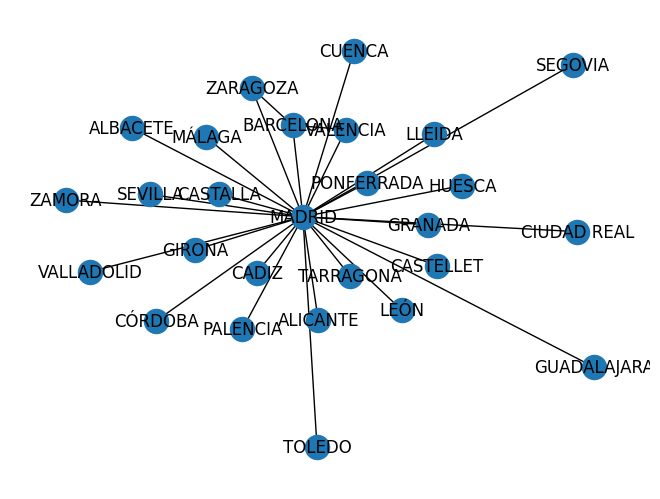

In [48]:
biadj =biadjacency.to_numpy()
G = nx.from_numpy_array(biadj);
nx.draw(G, labels=dico)

On peut constater avec ce premier graphe que le réseau de TGV est centré sur Madrid, et qu'il n'y a peu ou pas trajet direct entre 2 villes.

#### Graphe final
Le graphe final est celui pour lequel les noeuds sont positionnés aux coordonnées GPS exactes de la ville et que l'ensemble est délimité par une représentation des frontières géographique de l'Espagne.

Pour avoir les frontières géographique de l'Espagne, nous utilisons la librairie geopandas, qui fourni les coordonnées des points du polygone représentant les frontières de l'Espagne.

In [49]:
path_to_data = geopandas.datasets.get_path('naturalearth_lowres')
gdf = geopandas.read_file(path_to_data)
gdf.head(10)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
5,18513930.0,Asia,Kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918..."
6,33580650.0,Asia,Uzbekistan,UZB,57921,"POLYGON ((55.96819 41.30864, 55.92892 44.99586..."
7,8776109.0,Oceania,Papua New Guinea,PNG,24829,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ..."
8,270625568.0,Asia,Indonesia,IDN,1119190,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ..."
9,44938712.0,South America,Argentina,ARG,445445,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."


In [50]:
shape = gdf["geometry"].loc[gdf.name == "Spain"]

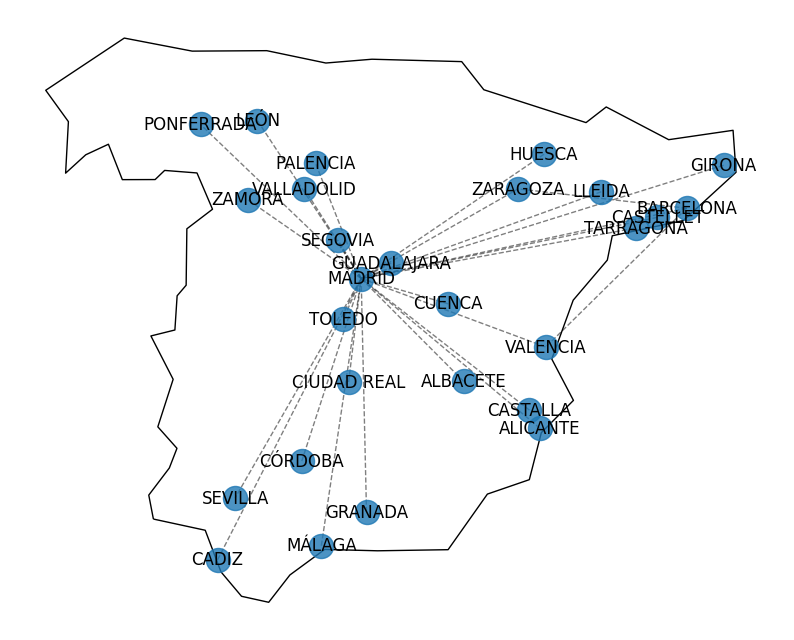

In [181]:
plt.figure(figsize=(10,12))
ax = plt.gca()
ax.set_axis_off()
shape.plot(ax=ax,color="white", edgecolor="black");
nx.draw_networkx_nodes(G, dico_2d_point, alpha=0.8);
nx.draw_networkx_labels(G, dico_2d_point, labels=dico);
nx.draw_networkx_edges(G, dico_2d_point,alpha=0.5, edge_color="k", style="dashed");


On a enfin le graphe finale montrant les liens TGV entre les différentes villes de l'Espagne

# Prediction


In [79]:
df_copy = df.copy()

In [81]:
df_copy.head(5)

,id,origin,destination,departure,departure_day,departure_date,departure_time,arrival,arrival_day,arrival_date,arrival_time,duration,"duration (d,H,M,S)",vehicle_type,vehicle_class,price,fare
0,1,MADRID,BARCELONA,2019-04-18 05:50:00,Thursday,2019-04-18,05:50:00,2019-04-18 08:55:00,Thursday,2019-04-18,08:55:00,3.08,"(0, 3, 5, 0)",AVE,Preferente,68.95,Promo
1,21,MADRID,BARCELONA,2019-04-18 13:25:00,Thursday,2019-04-18,13:25:00,2019-04-18 16:24:00,Thursday,2019-04-18,16:24:00,2.98,"(0, 2, 59, 0)",AVE-TGV,Turista,107.70,Flexible
2,41,MADRID,BARCELONA,2019-04-18 07:00:00,Thursday,2019-04-18,07:00:00,2019-04-18 09:30:00,Thursday,2019-04-18,09:30:00,2.50,"(0, 2, 30, 0)",AVE,Turista Plus,106.75,Promo
3,61,MADRID,BARCELONA,2019-05-18 17:30:00,Saturday,2019-05-18,17:30:00,2019-05-18 20:40:00,Saturday,2019-05-18,20:40:00,3.17,"(0, 3, 10, 0)",AVE,Turista,75.40,Promo
4,81,MADRID,BARCELONA,2019-05-22 08:00:00,Wednesday,2019-05-22,08:00:00,2019-05-22 10:30:00,Wednesday,2019-05-22,10:30:00,2.50,"(0, 2, 30, 0)",AVE,Turista,100.40,Promo


In [82]:
def dropcolumns(df):
    df_dropped = df.drop(['departure','departure_date','departure_time','arrival','arrival_day',
                          'arrival_date','arrival_time','duration (d,H,M,S)','vehicle_type'], axis=1)
    return df_dropped

df_copy = dropcolumns(df_copy)

In [83]:
df_copy.reset_index()
df_copy.head(5)

,id,origin,destination,departure_day,duration,vehicle_class,price,fare
0,1,MADRID,BARCELONA,Thursday,3.08,Preferente,68.95,Promo
1,21,MADRID,BARCELONA,Thursday,2.98,Turista,107.70,Flexible
2,41,MADRID,BARCELONA,Thursday,2.50,Turista Plus,106.75,Promo
3,61,MADRID,BARCELONA,Saturday,3.17,Turista,75.40,Promo
4,81,MADRID,BARCELONA,Wednesday,2.50,Turista,100.40,Promo


In [105]:
df_test = df_copy.loc[(df_copy.origin =="MADRID") & (df_copy.destination == "BARCELONA")]
df_test = pd.get_dummies(df_test, drop_first=True)
y = np.array(df_test.price)
X = np.array(df_test.drop(columns=["price","id"]))
df_test.head(5)

,id,duration,price,departure_day_Monday,departure_day_Saturday,departure_day_Sunday,departure_day_Thursday,departure_day_Tuesday,departure_day_Wednesday,vehicle_class_Turista,vehicle_class_Turista Plus,vehicle_class_Turista con enlace,vehicle_class_TuristaSólo plaza H,fare_Básica,fare_COD.PROMOCIONAL,fare_Flexible,fare_Mesa,fare_Promo,fare_Promo +,fare_YOVOY
0,1,3.08,68.95,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,21,2.98,107.70,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
2,41,2.50,106.75,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
3,61,3.17,75.40,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,81,2.50,100.40,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0


In [100]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [126]:
reg_lin = LinearRegression().fit(X_train, y_train)

In [131]:
reg_lin.score(X_test,y_test)

0.6493768309393726

In [133]:
reg_lin.score(X_train,y_train)

0.6481343540996447

In [132]:
from sklearn.metrics import mean_squared_error as MSE_err

In [137]:
MSE_err(y_test,reg_lin.predict(X_test))

181.93380450975008

In [139]:
MSE_err(y_train,reg_lin.predict(X_train))

183.11921860649656

In [182]:
#reg_lin.predict(np.reshape(X_test[0],(-1, 1)))

In [183]:
#np.reshape(X_test[0],(-1, 1))